In [1]:
cd /tf/astromer

/tf/astromer


In [67]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys,os
from core.data import pretraining_records
from core.input import input_format
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
dataset = pretraining_records('./data/records/macho2/train', 128, max_obs=50)

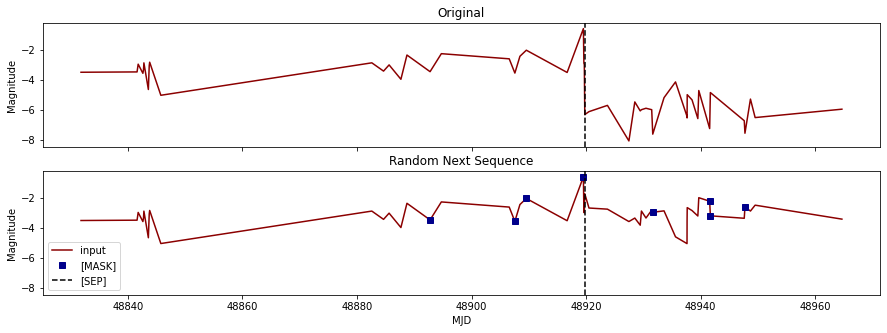

In [78]:
fig, axes = plt.subplots(2, 1, figsize=(15,5), sharex=True, sharey=True)
for batch in dataset:
    xx, tt, mm = input_format(batch)
    
#     print(batch['length'].shape)
#     print(batch['input'].shape)
#     print(batch['times'].shape)
#     print(batch['mask'].shape)
    x_sample = batch['input'][-1]
    o_sample = batch['original'][-1]
    t_sample = batch['times'][-1]
    m_sample = tf.squeeze(batch['mask'][-1])

    y_sample = batch['label'][-1]
        
    times = tf.boolean_mask(t_sample, m_sample)
    serie = tf.boolean_mask(x_sample, m_sample)
    serie2 = tf.boolean_mask(o_sample, m_sample)
    
    axes[0].plot(t_sample, x_sample, color='darkred')
   
    axes[0].axvline(t_sample[t_sample.shape[0]//2], color='k', linestyle='--')
    
    axes[1].plot(t_sample, o_sample, color='darkred', label='input')
    axes[1].plot(times, serie2, color='darkblue', marker='s', linestyle='', label='[MASK]')
    axes[1].axvline(t_sample[t_sample.shape[0]//2], color='k', linestyle='--', label='[SEP]')
    
    axes[0].set_title('Original')
    if y_sample == 1:
        axes[1].set_title('Random Next Sequence')
    else:
        axes[1].set_title('NonRandom Next Sequence')
    axes[1].set_xlabel('MJD')
    axes[0].set_ylabel('Magnitude')
    axes[1].set_ylabel('Magnitude')
    
    axes[1].legend()
    break